In [1]:
#!/usr/bin/env python
# coding: utf-8
# (c) Charles Le Losq, Clément Ferraina 2023
# see embedded licence file
# iVisc 1.0

#
# Library Loading
#
import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import numpy as np
np.random.seed = 167 # fix numpy random seed for reproducibility

import time, os

# local imports
import gpvisc.utils as utils
import gpvisc.models as models

# import sklearn models
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

# import sklearn utils
from sklearn.metrics import root_mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit

# import joblib (save and load models)
import joblib

# import xgboost
import xgboost as xgb

#
# Helper function for performance evaluation
#

def evaluate_model(ds, model, model_name="Don't forget this..."):

    y_train_valid_pred = model.predict(ds.TPX_train_valid_scaled)
    y_test_pred = model.predict(ds.TPX_test_scaled)

    mse_train = root_mean_squared_error(ds.y_train_valid, y_train_valid_pred)
    mse_test = root_mean_squared_error(ds.y_test, y_test_pred)
    mse_test_ourdatabase = root_mean_squared_error(ds.y_test[ds.Sciglass_test.ravel() == False], y_test_pred[ds.Sciglass_test.ravel() == False])

    mae_train = median_absolute_error(ds.y_train_valid, y_train_valid_pred)
    mae_test = median_absolute_error(ds.y_test, y_test_pred)
    mae_test_ourdatabase = median_absolute_error(ds.y_test[ds.Sciglass_test.ravel() == False], y_test_pred[ds.Sciglass_test.ravel() == False])

    r2_train = r2_score(ds.y_train_valid, y_train_valid_pred)
    r2_test = r2_score(ds.y_test, y_test_pred)
    r2_test_ourdatabase = r2_score(ds.y_test[ds.Sciglass_test.ravel() == False], y_test_pred[ds.Sciglass_test.ravel() == False])

    #Stats data
    print(model_name)
    print('Root Mean Square Errors:','\n',
          'Train-Valid    %.2f' % mse_train,'\n',
          'Test     %.2f' % mse_test,'\n',
          'Test (our data) %.2f' % mse_test_ourdatabase,'\n',
          'Median Absolute Errors:','\n',
          'Train-Valid    %.2f' % mae_train,'\n',
          'Test     %.2f' % mae_test,'\n',
          'Test (our data) %.2f' % mae_test_ourdatabase,'\n',
          'Coefficient of Determination:','\n',
          'Train-Valid    %.3f' % r2_train,'\n',
          'Test     %.3f' % r2_test,
          'Test (our data) %.3f' % r2_test_ourdatabase,'\n'
         )

# Data loading

We use utils.data_loader to load the data for training the black box models.

In [2]:
# Data loading
print("Loading the viscosity datasets...")
ds = utils.data_loader()
print("Loaded.")

Loading the viscosity datasets...
Loaded.


## further data preparation

We now train the algorithms on the train-valid splits for final training. For tuning of hyperparameters, see the other notebook.

We thus rescale the data using the train-valid split, and transform the train-valid and test datasets using this scaler.

In [3]:
# preparing data scaling

stop_col = 14 # we only use the first 14 columns as in the other models
scaler = StandardScaler().fit(ds.TPX_train_valid[:,:stop_col])
ds.TPX_train_valid_scaled = scaler.transform(ds.TPX_train_valid[:,:stop_col])
ds.TPX_test_scaled = scaler.transform(ds.TPX_test[:,:stop_col])

# Models with SciKit Learn

With scikit learn, we will try four popular, out of the box blackbox models:
- a linear model will be used as a baseline model;
- a support vector machine regression model;
- a random forest model (note that we tried XGBoost and it makes not that much differences, so we stick with scikit-learn for this example);
- an artificial neural network model.

#### Linear model

In [ ]:
# Declaration
clf_linreg = linear_model.LinearRegression()

# Training and Saving
clf_linreg.fit(ds.TPX_train_valid_scaled,
               ds.y_train_valid)
joblib.dump(clf_linreg,'./models/clf_linreg.joblib')

# Evaluation
evaluate_model(ds, clf_linreg, model_name="## Linear Regression ##")

## Linear Regression ##
Root Mean Square Errors: 
 Train-Valid    1.58 
 Test     1.58 
 Test (our data) 1.51 
 Median Absolute Errors: 
 Train-Valid    1.08 
 Test     1.09 
 Test (our data) 0.91 
 Coefficient of Determination: 
 Train-Valid    0.873 
 Test     0.872 Test (our data) 0.903 



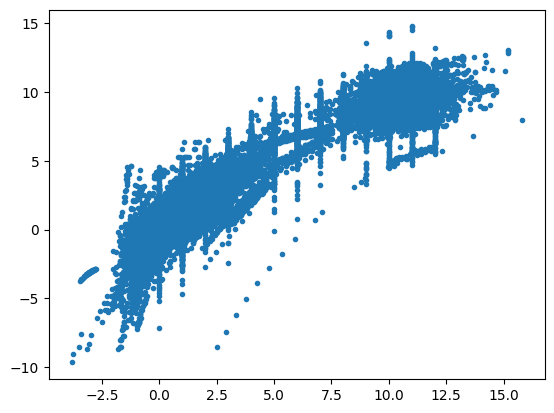

In [5]:
plt.plot(ds.y_train_valid, clf_linreg.predict(ds.TPX_train_valid_scaled),".")

#### Support Vector Machine regression

Train a SVR model with the best hyperparameters selected using Bayesian optimization.

In [6]:
# Declaration
clf_svr = SVR(kernel = 'rbf', 
              C=298, 
              epsilon=0.000219, 
              cache_size=1000)

# Training and Saving
clf_svr.fit(ds.TPX_train_valid_scaled, 
            ds.y_train_valid)
joblib.dump(clf_svr,'./models/clf_svr.joblib')

# Evaluation
evaluate_model(ds, clf_svr, model_name = "SVR REGRESSION")

/home/charles/miniconda3/envs/gpvisc/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR REGRESSION
Root Mean Square Errors: 
 Train-Valid    0.46 
 Test     0.53 
 Test (our data) 0.36 
 Median Absolute Errors: 
 Train-Valid    0.09 
 Test     0.15 
 Test (our data) 0.13 
 Coefficient of Determination: 
 Train-Valid    0.989 
 Test     0.986 Test (our data) 0.994 



## Artificial neural network

The architecture of the ANN was tuned by hand. The default learning rate already allows obtaining reasonable results with minimal overfitting, such that we did not search to tune it further.

In [5]:
# Declaration
clf_nn = MLPRegressor(solver='adam', 
                      alpha=1e-3, 
                      hidden_layer_sizes=(200,200),
                      activation='relu', 
                      max_iter=20000
                      )

# Training and Saving
clf_nn.fit(ds.TPX_train_valid_scaled, ds.y_train_valid)
joblib.dump(clf_nn,'./models/clf_nn.joblib')

# Evaluation
evaluate_model(ds, clf_nn, model_name = "ANN REGRESSION")

/home/charles/miniconda3/envs/gpvisc/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ANN REGRESSION
Root Mean Square Errors: 
 Train-Valid    0.38 
 Test     0.44 
 Test (our data) 0.33 
 Median Absolute Errors: 
 Train-Valid    0.14 
 Test     0.17 
 Test (our data) 0.16 
 Coefficient of Determination: 
 Train-Valid    0.993 
 Test     0.990 Test (our data) 0.995 



## Random Forest

In [8]:
# Declaration
clf_rf = RandomForestRegressor(
    n_estimators = 149,
    max_depth = 20,
    min_samples_split = 2,
    min_samples_leaf = 1)

# Training and Saving
clf_rf.fit(ds.TPX_train_valid_scaled, ds.y_train_valid)
joblib.dump(clf_rf,'./models/clf_rf.joblib')

# Evaluation
evaluate_model(ds, clf_rf, model_name = "Random Forest REGRESSOR")

/home/charles/miniconda3/envs/gpvisc/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest REGRESSOR
Root Mean Square Errors: 
 Train-Valid    0.19 
 Test     0.54 
 Test (our data) 0.37 
 Median Absolute Errors: 
 Train-Valid    0.05 
 Test     0.14 
 Test (our data) 0.13 
 Coefficient of Determination: 
 Train-Valid    0.998 
 Test     0.985 Test (our data) 0.994 



## XGBoost regressor

Hyperparameters were tuned using Optuna (see notebook 4ter).

In [9]:
# Declaration
xgb_params = {'n_estimators': 893, 
              'max_depth': 9, 
              'eta': 0.03186217323374842, 
              'subsample': 0.9079053385183469, 
              'colsample_bytree': 0.9473360174104577}
clf_xgb = xgb.XGBRegressor(**xgb_params)

# Training and Saving
clf_xgb.fit(ds.TPX_train_valid_scaled, 
            ds.y_train_valid,
            verbose=False)
joblib.dump(clf_xgb,'./models/clf_xgb.joblib')

# Evaluation
evaluate_model(ds, clf_xgb, model_name = "XGBoost REGRESSION")

XGBoost REGRESSION
Root Mean Square Errors: 
 Train-Valid    0.20 
 Test     0.47 
 Test (our data) 0.37 
 Median Absolute Errors: 
 Train-Valid    0.07 
 Test     0.15 
 Test (our data) 0.14 
 Coefficient of Determination: 
 Train-Valid    0.998 
 Test     0.989 Test (our data) 0.994 



In [10]:
print("Models saved with joblib version {}".format(joblib.__version__))

Models saved with joblib version 1.4.2
